# GSA plots

Notebook for visualizing GSA results.

2020-09-28

## Initial boilerplate

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

## 1. Loading data

Loading output from goseq:

In [2]:
import pandas as pd

clasifications = ['GOterms', 'KEGGpathways', 'KEGGmodules']
comparisons = ['KCl_vs_Control', 'NaCl_vs_Control', 'KCl_vs_NaCl']
directions = ['overexpressed', 'repressed']
results = {}
for clasification in clasifications:
    for comparison in comparisons:
        for direction in directions:
            file_name = join(FINAL,f"{clasification}_goseq_on_{comparison}_{direction}.tabular")
            new_df = pd.read_csv(file_name, index_col=0, sep="\t")
            if clasification == "KEGGpathways":
                file_name = join(RAW_EXTERNAL,"KEGG_Dh_pathwaysID.csv")
                kegg_codes = pd.read_csv(file_name, index_col=0, sep=",")
                for (idx, row) in new_df.iterrows():
                    new_df.loc[idx,"term"] = kegg_codes.loc[idx,"name"]
            results[f"{clasification}_{comparison}_{direction}"]  = new_df

## 2. Building dataframes

Let's first see how many significant terms we have in each group:

In [3]:
summary_df = pd.DataFrame()
idx = 0
for clasification in clasifications:
    for comparison in comparisons:
        for direction in directions:
            df = results[f"{clasification}_{comparison}_{direction}"]
            is_over = df["p.adjust.over_represented"] < 0.05
            is_under = df["p.adjust.under_represented"] < 0.05
            new_line = pd.DataFrame(index = [idx], data = {"clasification":clasification,
                                                           "comparison":comparison,
                                                           "direction":direction,
                                                           "n_over":sum(is_over),
                                                           "n_under":sum(is_under),
                                                           "groups_over":' - '.join(df.index[is_over]),
                                                           "groups_under":' - '.join(df.index[is_under])})
            summary_df = summary_df.append(new_line)
            idx += 1
                                            
summary_df

,clasification,comparison,direction,n_over,n_under,groups_over,groups_under
0,GOterms,KCl_vs_Control,overexpressed,7,0,GO:0005840 - GO:0003735 - GO:0006412 - GO:0005...,
1,GOterms,KCl_vs_Control,repressed,6,0,GO:0003824 - GO:0055085 - GO:0006526 - GO:0000...,
2,GOterms,NaCl_vs_Control,overexpressed,7,0,GO:0009986 - GO:0030446 - GO:0016491 - GO:0009...,
3,GOterms,NaCl_vs_Control,repressed,1,0,GO:0006526,
4,GOterms,KCl_vs_NaCl,overexpressed,0,0,,
5,GOterms,KCl_vs_NaCl,repressed,2,0,GO:0005315 - GO:0006817,
6,KEGGpathways,KCl_vs_Control,overexpressed,3,2,dha03010 - dha00100 - dha00740,dha00970 - dha04144
7,KEGGpathways,KCl_vs_Control,repressed,13,2,dha01100 - dha01110 - dha00280 - dha01230 - dh...,dha00970 - dha03010
8,KEGGpathways,NaCl_vs_Control,overexpressed,10,0,dha00010 - dha01100 - dha01200 - dha01110 - dh...,
9,KEGGpathways,NaCl_vs_Control,repressed,5,0,dha01230 - dha00220 - dha01100 - dha01110 - dh...,


Now let's build datframes for each classification:

In [4]:
# build enrichment dataframe:
def build_enrichment_df(clasification):
    enrichment_df = pd.DataFrame(columns = ["full_name"] + comparisons)
    for comparison in comparisons:
        for direction in directions:
            df = results[f"{clasification}_{comparison}_{direction}"]
            for (idx, row) in df.iterrows():
                if row["p.adjust.over_represented"] < 0.05 and row["numInCat"] >= 5:
                    if idx not in enrichment_df.index:
                        enrichment_df.append(pd.DataFrame(index = [idx]))
                        try:
                            full_name = results[f"{clasification}_{comparison}_{direction}"].loc[idx,"term"]
                            full_name = full_name.replace("involved in conjugation with cellular fusion","")
                            enrichment_df.loc[idx,"full_name"] = full_name
                        except:
                            pass
                    if direction == "overexpressed":
                        fc_sign = +1
                    else:
                        fc_sign = -1
                    enrichment_df.loc[idx,comparison] = fc_sign*row["numDEInCat"]/row["numInCat"]
    return enrichment_df

go_df = build_enrichment_df("GOterms")
go_df

,full_name,KCl_vs_Control,NaCl_vs_Control,KCl_vs_NaCl
GO:0005840,ribosome,0.486486,NaN,NaN
GO:0003735,structural constituent of ribosome,0.459016,NaN,NaN
GO:0006412,translation,0.452991,NaN,NaN
GO:0005622,intracellular,0.252294,NaN,NaN
GO:0009986,cell surface,0.309735,0.168142,NaN
GO:0005576,extracellular region,0.273684,NaN,NaN
GO:0009231,riboflavin biosynthetic process,0.833333,NaN,NaN
GO:0003824,catalytic activity,-0.147335,NaN,NaN
GO:0055085,transmembrane transport,-0.148014,0.0830325,NaN
GO:0000750,pheromone-dependent signal transduction,-0.714286,NaN,NaN


In [5]:
kegg_pathway_df = build_enrichment_df("KEGGpathways")
kegg_pathway_df

,full_name,KCl_vs_Control,NaCl_vs_Control,KCl_vs_NaCl
dha03010,ribosome,0.5,NaN,NaN
dha00100,steroid biosynthesis,0.5,0.25,NaN
dha00740,riboflavin metabolism,0.6,NaN,NaN
dha01100,metabolic pathways,-0.09375,-0.04375,NaN
dha01110,biosynthesis of secondary metabolites,-0.11976,-0.0598802,NaN
dha00280,"valine, leucine and isoleucine degradation",-0.368421,NaN,NaN
dha01230,biosynthesis of amino acids,-0.163636,-0.145455,NaN
dha00071,fatty acid degradation,-0.307692,NaN,NaN
dha00620,pyruvate metabolism,-0.243902,0.170732,NaN
dha00500,starch and sucrose metabolism,-0.266667,NaN,NaN


In [6]:
kegg_module_df = build_enrichment_df("KEGGmodules")
kegg_module_df

,full_name,KCl_vs_Control,NaCl_vs_Control,KCl_vs_NaCl
dhaM00102,NaN,0.75,NaN,NaN
dhaM00158,NaN,0.533333,NaN,NaN
dhaM00002,NaN,NaN,0.75,NaN
dhaM00001,NaN,NaN,0.466667,NaN
dhaM00003,NaN,NaN,0.5,NaN


## 3. Barplots

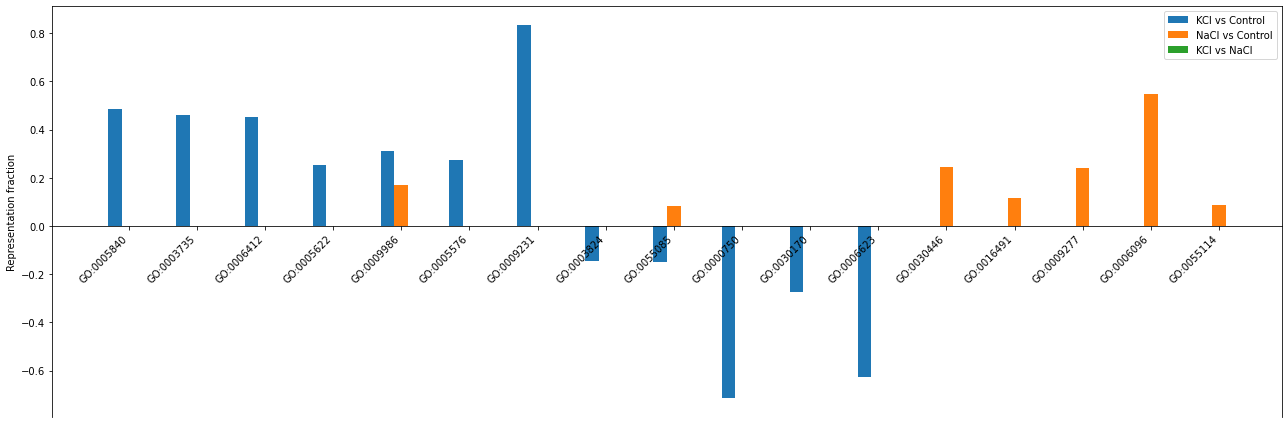

In [7]:
import numpy as np
from matplotlib import pyplot as plt

def barplot(df,fig_width):
    # plot results
    labels = df.index
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    pos = -width
    for comparison in comparisons:
        ax.bar(x + pos, df[comparison], width, label=comparison.replace('_',' '))
        pos += width
    ax.set_ylabel('Representation fraction')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.spines['bottom'].set_position(('data', 0))
    ax.legend(loc=1)
    fig.tight_layout()
    plt.xticks(rotation=45, ha="right")
    plt.show()

barplot(go_df,18)

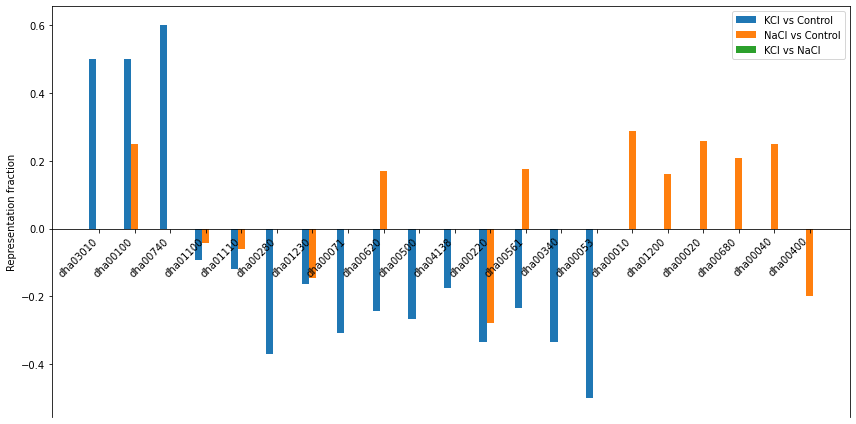

In [8]:
barplot(kegg_pathway_df,12)

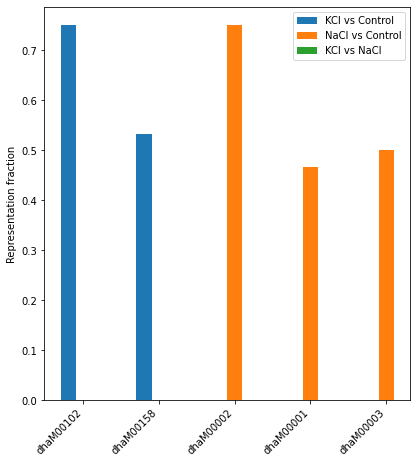

In [9]:
barplot(kegg_module_df,6)

## 4. Heatmaps

In [10]:
# compute expected represented value and replace NA values with it:
def replace_nans(df):
    bases = {}
    for comparison in comparisons:
        file_name = join(INTERMEDIATE,f"Tables_edgeR_{comparison.replace('_vs_','-')}.tabular")
        dea_df = pd.read_csv(file_name, index_col=0, sep="\t")
        bases[comparison] = sum(dea_df["FDR"] < 0.05)/len(dea_df.index)
        df[comparison] = df[comparison].fillna(bases[comparison])
    return df, bases

df, bases = replace_nans(go_df)
bases

{'KCl_vs_Control': 0.1537042729787888,
 'NaCl_vs_Control': 0.06255763910236704,
 'KCl_vs_NaCl': 0.0012296341838303104}

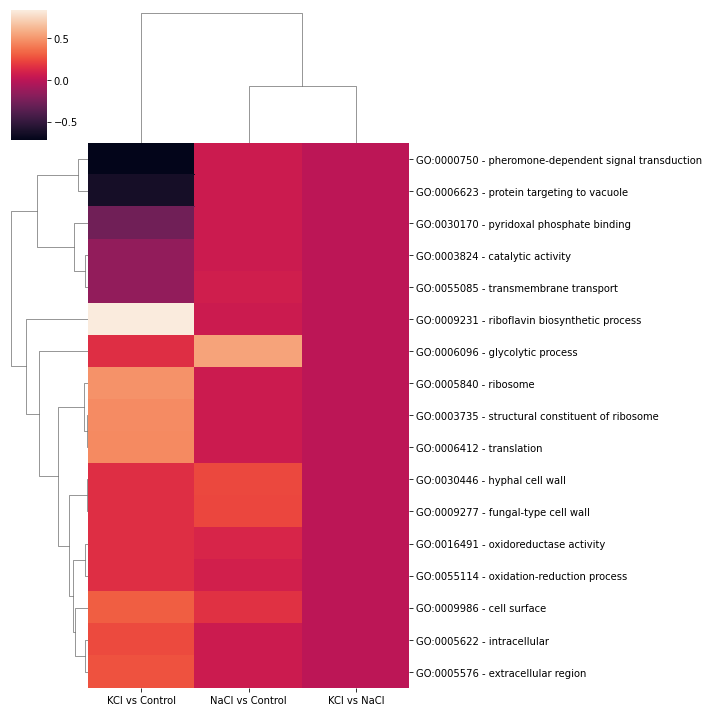

In [11]:
import seaborn as sns

def heatmap(df):
    # pre-process:
    df, bases = replace_nans(df)
    df.index = list(map(str.__add__, df.index + [" - "], df["full_name"].tolist()))
    df = df.drop(columns=["full_name"])
    df.columns = [name.replace("_"," ") for name in df.columns.tolist()]
    # plot:
    sns.clustermap(df)

heatmap(go_df)

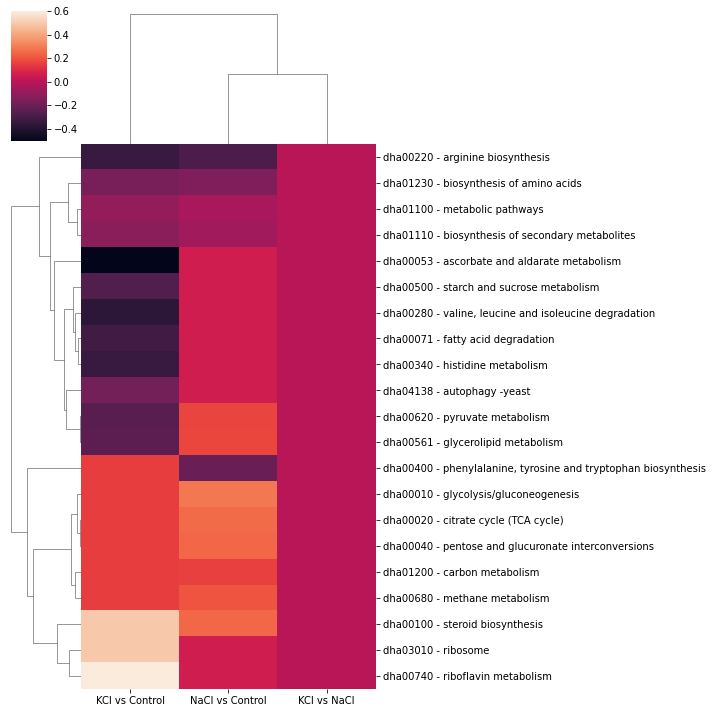

In [12]:
heatmap(kegg_pathway_df)

In [13]:
heatmap(kegg_module_df)

TypeError: can only concatenate str (not "float") to str